In [1]:
import numpy as np
import HARK
from HARK.distribution import MVLogNormal
from scipy.optimize import root_scalar
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib import pyplot as plt

In [118]:
class BufferStockModel:

    def __init__(self, ρ = 4, Γ = 1.03, ℜ = 1.04, Rf = 1.01, β = 0.93, Σ = np.array([[0.01, 0.0, 0.0], [0.0, 0.0225, 0.0], [0.0, 0.0, 0.01]])):

        self.ρ, self.Γ, self.ℜ, self.Rf, self.β, self.Σ = ρ, Γ, ℜ, Rf, β, Σ

        self.μ = - np.diag(Σ) / 2
        
        self.shocks = MVLogNormal(self.μ, self.Σ)

    def u(self, c):

        ρ = self.ρ

        if ρ == 1:
            return np.log(c)
        elif ρ >= 0:
            return (c ** (1 - ρ)) / (1 - ρ)
        else:
            raise ValueError("ρ must be non-negative")

    def u_prime(self, c):

        ρ = self.ρ

        if ρ < 0:
            raise ValueError("ρ must be non-negative")
        elif ρ == 0:
            return 1
        else:
            return c ** (-ρ)

    def m1(self, a, κ, atom):

        η, ν, ζ = atom

        ℜ, Γ, Rf = self.ℜ, self.Γ, self.Rf

        R_eff = Rf + κ * (ν * ℜ - Rf)

        G_eff = Γ * η

        mNrm = R_eff * a / G_eff + ζ

        return mNrm

    def m2(self, a, κ, atom):

        η, ν, ζ = atom

        ℜ, Γ, Rf = self.ℜ, self.Γ, self.Rf

        R_eff = Rf + κ * (ν * ℜ - Rf)

        G_eff = Γ * η

        mNrm = R_eff * a / G_eff

        return mNrm

    def κ_euler(self, κ, a, c_next):

        Rf, ℜ, Γ, ρ, ξ, shocks_approx = self.Rf, self.ℜ, self.Γ, self.ρ, self.ξ, self.shocks_approx

        def ℓ1(atom):
            return self.m1(a, κ, atom)

        def ℓ2(atom):
            return self.m2(a, κ, atom)

        def g(atom):

            η, ν, ζ = atom

            return ((ℜ * ν) - Rf) * ((Γ * η) ** (-ρ)) * ((1 - ξ) * self.u_prime(c_next(ℓ1(atom))) + ξ * self.u_prime(c_next(ℓ2(atom))))

        return shocks_approx.expected(func = g)

    def κ_hat(self, a, c_next):

        shocks_approx = self.shocks_approx

        κ_func = lambda κ : self.κ_euler(κ, a, c_next)

        κ = root_scalar(κ_func, method="newton", x0 = 0.5)['root']

        return κ

    def c_hat(self, a, κ, c_next):

        β, Rf, ℜ, Γ, ρ, ξ, shocks_approx = self.β, self.Rf, self.ℜ, self.Γ, self.ρ, self.ξ, self.shocks_approx

        def ℓ1(atom):

            return self.m1(a, κ, atom)

        def ℓ2(atom):

            return self.m2(a, κ, atom)

        def c_rho(atom):

            η, ν, ζ = atom

            return β * (Rf + κ * (ℜ * ν - Rf)) * ((Γ * η) ** (-ρ)) * ((1 - ξ) * self.u_prime(c_next(ℓ1(atom))) + ξ * self.u_prime(c_next(ℓ2(atom))))

        return shocks_approx.expected(func = c_rho) ** (-1/ρ)

    def discretize_distribution(self, N, tail_bound = [0.0015, 0.9985], decomp="cholesky", endpoints = True):

        self.shocks_approx = self.shocks._approx_equiprobable(N = N, tail_bound = tail_bound, decomp=decomp, endpoints=endpoints)

    def gen_asset_grid(self, aMax, n = 20, boroConst = True, artBoroConst = 0, ξ = 0.005):

        worst = self.shocks_approx.atoms.min(axis=1)

        ηMin, νMin, ζMin = worst

        Γ, ℜ = self.Γ, self.ℜ

        if boroConst:
            if artBoroConst == 0.0:
                aMin = 1e-5
            else:
                aMin = artBoroConst

            self.ξ = 0
        else:
            aMin = 1e-5
            self.ξ = ξ

        aDiffs = np.exp(np.linspace(-4, np.log(aMax - aMin), n-1))

        aNrmGrid = np.empty(n)

        aNrmGrid[0] = aMin
        aNrmGrid[1:] = aMin + aDiffs

        self.aNrmGrid = aNrmGrid
        self.boroConst = boroConst

    def pre_solve(self, N = 10, aMax = 6, tail_bound = [0.0015, 0.9985], decomp="cholesky", endpoints = True, n = 20, boroConst = True, artBoroConst = 0, ξ = 0.005):

        self.discretize_distribution(N = N, tail_bound = tail_bound, decomp=decomp, endpoints=endpoints)

        self.gen_asset_grid(aMax = aMax, n = n, boroConst = boroConst, artBoroConst = artBoroConst, ξ = ξ)

    def solve(self, T = None, c_guess = lambda x : x, interp="linear", max_iter = 100, tol=1e-6):

        boroConst = self.boroConst
        aNrmGrid = self.aNrmGrid
        n = len(aNrmGrid)

        if T is None:
            c_T = c_guess
            t = 0
            iter = 0
            error = tol + 1
        else:
            t = T
            c_T = lambda x : x
            iter = max_iter + 1
            error = tol - 1

        policies = [{'cFunc' : c_T}]

        while (t > 0) or ((T is None) & (iter < max_iter) & (error > tol)):
            c_next = policies[-1]['cFunc']
            
            κ_hat_vec = np.vectorize(lambda a : self.κ_hat(a, c_next))

            κ_opt = κ_hat_vec(aNrmGrid)

            κGrid = np.where(κ_opt > 1, 1, np.where(κ_opt < 0, 0, κ_opt))

            def c_hat_opt(a, κ):

                return self.c_hat(a, κ, c_next)

            c_hat_vec = np.vectorize(c_hat_opt)

            cNrmGrid = c_hat_vec(aNrmGrid, κGrid)

            mNrmGrid = cNrmGrid + aNrmGrid

            if boroConst:
                κvals = np.empty(n+1)
                κvals[0] = κGrid[0]
                κvals[1:] = κGrid

                cvals = np.empty(n+1)
                cvals[0] = 0.0
                cvals[1:] = cNrmGrid

                mvals = np.zeros(n+1)
                mvals[1:] = mNrmGrid
            else:
                κvals = κGrid
                cvals = cNrmGrid
                mvals = mNrmGrid

            if interp=="linear":
                cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=1)
                κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)
            elif interp=="spline":
                cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
                κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=3)
            elif interp=="SL":
                cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
                κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)

            policies_t = {"cFunc":cFunc_t, "κFunc":κFunc_t, "mNrmGrid":mvals, "κGrid":κvals, "cNrmGrid":cvals}

            policies.append(policies_t)

            if T is not None:
                t -= 1
            else:
                iter += 1

                if iter > 1:
                    m_prev = policies[-2]['mNrmGrid']
                    κ_prev = policies[-2]['κGrid']
                    errors = np.array([np.max(np.abs(mvals - m_prev)), np.max(np.abs(κvals - κ_prev))])
                    error = np.max(errors)

        policies.reverse()

        params = {}

        if T is None:
            params['T'] = 'Infinite'
            params['error'] = error
            params['iter'] = iter
        else:
            params['T'] = T

        params['interp'] = interp

        self.policies = policies
        self.params = params

        self.gen_solution()

    def gen_solution(self):

        T = self.params['T']

        if T == 'Infinite':
            self.solution = self.policies[0]
        else:

            def solution(t : int):

                if t < 0:
                    raise ValueError("t must be non-negative")
                elif t > T:
                    raise ValueError("t must be between 0 and T")
                else:
                    return self.policies[t]

            self.solution = solution

    def plot_cFunc(self, mGrid = np.linspace(0, 10, 300), t = None):

        if (self.params['T'] == 'Infinite') and (t is not None):
            raise ValueError('The computed solution is for the infinite horizon model')
        elif (self.params['T'] != 'Infinite') and (t is None):
            raise ValueError('The solution to a finite horizon model must be provided for a given t')
        
        if t is None:
            plt.plot(mGrid, self.solution['cFunc'](mGrid), color = "black", linestyle="dashed", label = "$c(m)$")

            plt.legend()
            plt.show()
        else:
            plt.plot(mGrid, self.solution(t)['cFunc'](mGrid), color = "black", linestyle = "dashed", label = f'$c_{t}(m)$')

            plt.legend()
            plt.show()

    def plot_κFunc(self, mGrid = np.linspace(0, 10, 300), t = None):

        if (self.params['T'] == 'Infinite') and (t is not None):
            raise ValueError('The computed solution is for the infinite horizon model')
        elif (self.params['T'] != 'Infinite') and (t is None):
            raise ValueError('The solution to a finite horizon model must be provided for a given t')

        if t is None:
            plt.ylim((0, 1.1))
            plt.plot(mGrid, self.solution['κFunc'](mGrid), color = "black", label = "$\kappa(m)$")
            
            plt.legend()
            plt.show()
        else:
            plt.ylim((0, 1.1))
            plt.plot(mGrid, self.solution(t)['κFunc'](mGrid), color = "black", label = f"$\kappa_{t+1}(m)$")

            plt.legend()
            plt.show()

    def target_wealth(self, mGrid = np.linspace(0, 10, 300), t=None):
        if (self.params['T'] == 'Infinite') and (t is not None):
            raise ValueError('The computed solution is for the infinite horizon model')
        elif (self.params['T'] != 'Infinite') and (t is None):
            raise ValueError('The solution to a finite horizon model must be provided for a given t')

        if t is None:

            cFunc = self.solution['cFunc']
            κFunc = self.solution['κFunc']

            ℜ, Γ, Rf, ξ = self.ℜ, self.Γ, self.Rf, self.ξ
            shocks_approx = self.shocks_approx

            def ℓ(m, atom):

                η, ν, ζ = atom

                mNext = (m - cFunc(m)) * (Rf + κFunc(m) * (ℜ * ν - Rf)) / (Γ * η) + (1-ξ) * ζ

                return mNext

            def g(m):

                def f(atom):
                    return ℓ(m, atom)

                return shocks_approx.expected(func = f)

            mNext = np.empty(len(mGrid))

            for i in range(len(mNext)):
                mNext[i] = g(mGrid[i])

            mNextFunc = InterpolatedUnivariateSpline(mGrid, mNext, k=1)

            m = root_scalar(lambda m : mNextFunc(m) - m, method="newton", x0=3)['root']

            self.target_m = m

            return m

        else:

            cFunc = self.solution(t)['cFunc']
            κFunc = self.solution(t)['κFunc']

            ℜ, Γ, Rf, ξ = self.ℜ, self.Γ, self.Rf, self.ξ
            shocks_approx = self.shocks_approx

            def ℓ(m, atom):

                η, ν, ζ = atom

                mNext = (m - cFunc(m)) * (Rf + κFunc(m) * (ℜ * ν - Rf)) / (Γ * η) + (1-ξ) * ζ

                return mNext

            def g(m):

                def f(atom):
                    return ℓ(m, atom)

                return shocks_approx.expected(func = f)

            mNext = np.empty(len(mGrid))

            for i in range(len(mNext)):
                mNext[i] = g(mGrid[i])

            mNextFunc = InterpolatedUnivariateSpline(mGrid, mNext, k=1)

            m = root_scalar(lambda m : mNextFunc(m) - m, method="newton", x0=3)['root']

            return m


    def plot_targetκ(self, mGrid = np.linspace(0, 10, 300), t = None):
        if (self.params['T'] == 'Infinite') and (t is not None):
            raise ValueError('The computed solution is for the infinite horizon model')
        elif (self.params['T'] != 'Infinite') and (t is None):
            raise ValueError('The solution to a finite horizon model must be provided for a given t')

        if t is None:
            κFunc = self.solution['κFunc']

            ℜ, Γ, Rf = self.ℜ, self.Γ, self.Rf

            m = self.target_wealth()

            plt.plot(mGrid, κFunc(mGrid), color = "black", label = "$\kappa(m_{t})$")

            plt.axvline(x = m, color='black', linestyle='dashed', label="$m^*$")

            plt.legend()


    def plot_wealth_transition(self, mGrid = np.linspace(0, 5, 300), t=None):
        if (self.params['T'] == 'Infinite') and (t is not None):
            raise ValueError('The computed solution is for the infinite horizon model')
        elif (self.params['T'] != 'Infinite') and (t is None):
            raise ValueError('The solution to a finite horizon model must be provided for a given t')

        if t is None:

            cFunc = self.solution['cFunc']
            κFunc = self.solution['κFunc']

            ℜ, Γ, Rf, ξ = self.ℜ, self.Γ, self.Rf, self.ξ
            shocks_approx = self.shocks_approx

            def ℓ(m, atom):

                η, ν, ζ = atom

                mNext = (m - cFunc(m)) * (Rf + κFunc(m) * (ℜ * ν - Rf)) / (Γ * η) + (1-ξ) * ζ

                return mNext

            def g(m):

                def f(atom):
                    return ℓ(m, atom)

                return shocks_approx.expected(func = f)

            mNext = np.empty(len(mGrid))

            for i in range(len(mNext)):
                mNext[i] = g(mGrid[i])

            plt.plot(mGrid, mGrid, linestyle="dashed", color="black", label="$m_t$")
            plt.plot(mGrid, mNext, color="black", label="$\mathbb{E}_t[m_{t+1}]$")
            plt.legend()

In [3]:
consumer = BufferStockModel()

consumer.pre_solve(aMax = 300, n=70, boroConst=True, N = 12)

consumer.solve()

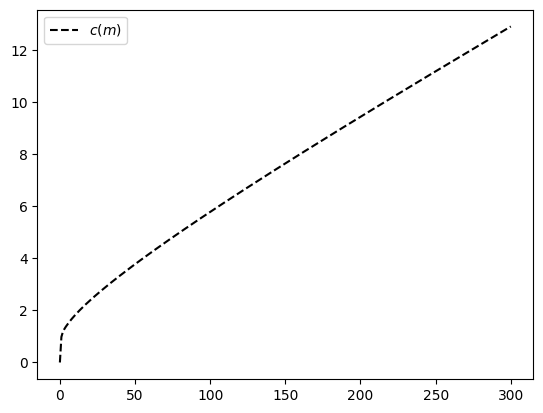

In [4]:
mGrid = np.linspace(0, 300, 300)

consumer.plot_cFunc(mGrid = mGrid)

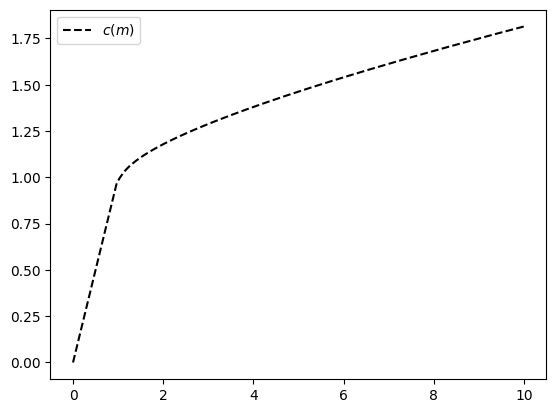

In [5]:
consumer.plot_cFunc()

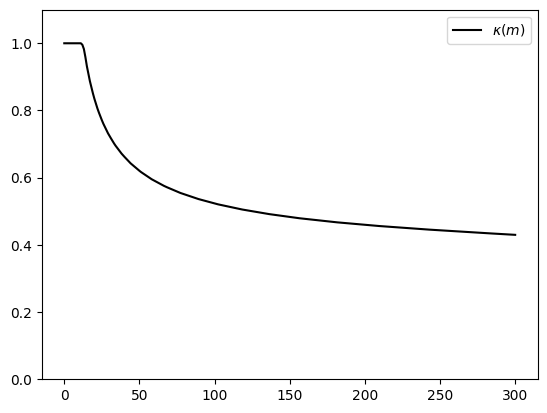

In [6]:
consumer.plot_κFunc(mGrid = mGrid)

In [7]:
m_star = consumer.target_wealth()
print(f'The target wealth for this consumer is {m_star}')

a_star = m_star - consumer.solution['cFunc'](m_star)
print(f'The target savings for this consumer is {a_star}')

κ_star = consumer.solution['κFunc'](m_star)
print(f'Consequently, this consumer invests {κ_star} proportion in equity')

The target wealth for this consumer is 1.0472725861332137
The target savings for this consumer is 0.04670384961645824
Consequently, this consumer invests 1.0 proportion in equity


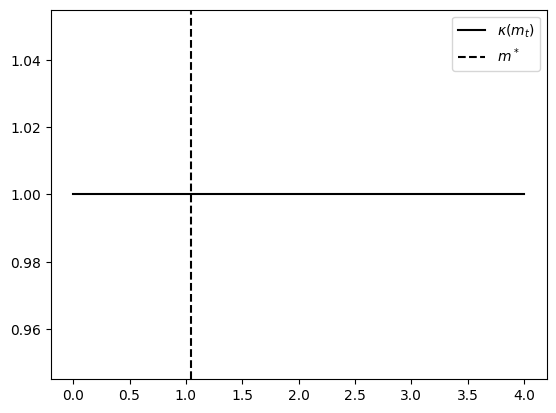

In [8]:
consumer.plot_targetκ(mGrid = np.linspace(0, 4, 100))

In [9]:
consumer = BufferStockModel()

consumer.pre_solve(aMax = 300, n=70, boroConst=False, N = 12)

consumer.solve()

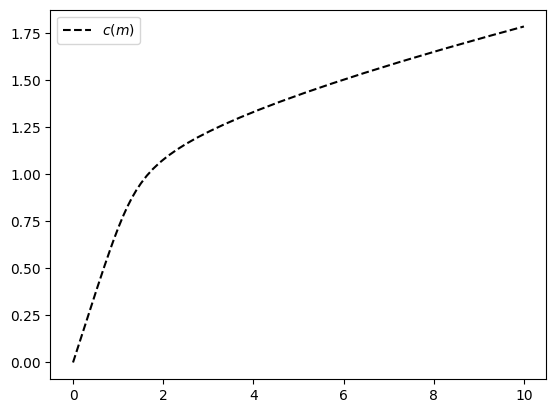

In [10]:
consumer.plot_cFunc()

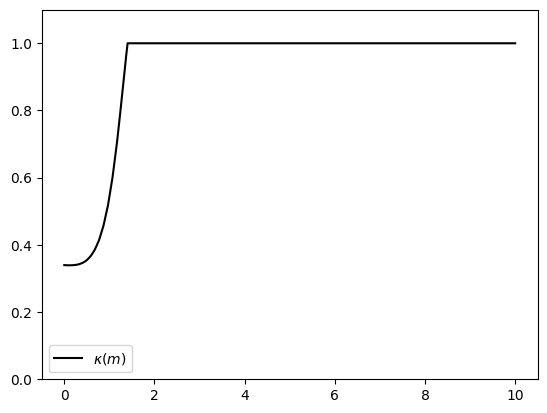

In [11]:
consumer.plot_κFunc()

In [ ]:
consumer.plot_κFunc(mGrid=mGrid)

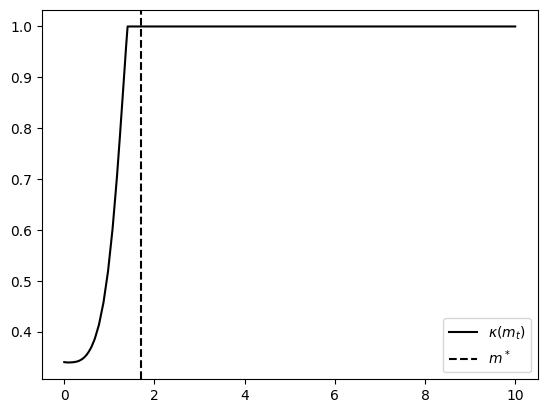

In [13]:
consumer.plot_targetκ()

In [92]:
def gen_cov_matrix(ω : float, kind = "P"):

    if kind == "P":
        Σ = np.array(
            [
                [0.01, ω, 0.0],
                [ω, 0.0225, 0.0],
                [0.0, 0.0, 0.01]
            ]
        )
    elif kind == "T":
        Σ = np.array(
            [
                [0.01, 0.0, 0.0],
                [0.0, 0.0225, ω],
                [0.0, ω, 0.01]
            ]
        )

    return Σ

In [119]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve()

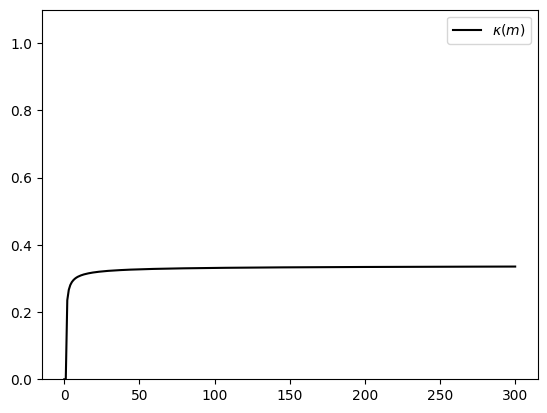

In [112]:
consumer.plot_κFunc(mGrid = mGrid)

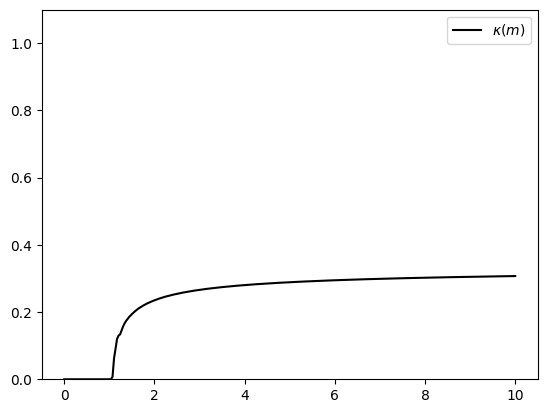

In [113]:
consumer.plot_κFunc()

In [114]:
m_star = consumer.target_wealth()
print(f'The target wealth for this consumer is {m_star}')

a_star = m_star - consumer.solution['cFunc'](m_star)
print(f'The target savings for this consumer is {a_star}')

κ_star = consumer.solution['κFunc'](m_star)
print(f'Consequently, this consumer invests {κ_star} proportion in equity')

The target wealth for this consumer is 1.027739984697966
The target savings for this consumer is 0.028092811082081837
Consequently, this consumer invests 0.0 proportion in equity


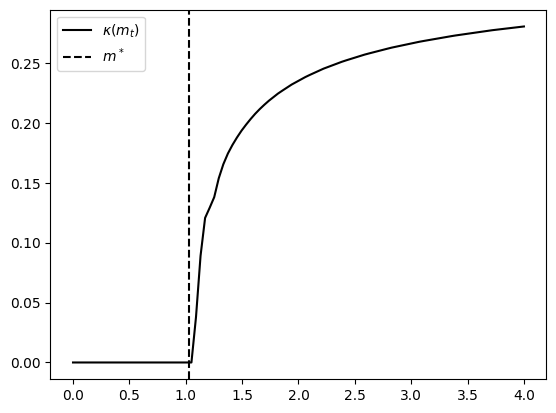

In [115]:
consumer.plot_targetκ(mGrid=np.linspace(0, 4, 100))

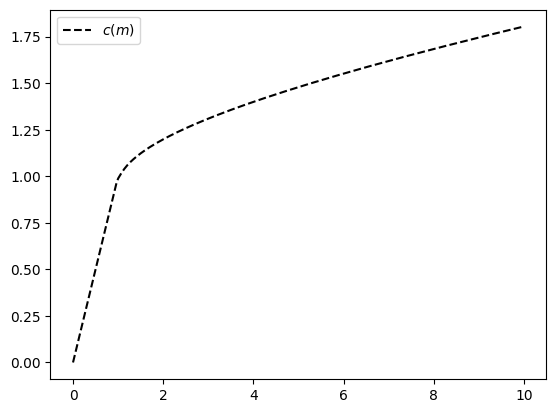

In [116]:
consumer.plot_cFunc()

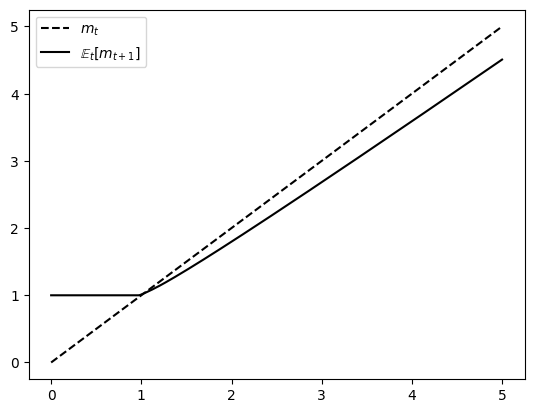

In [120]:
consumer.plot_wealth_transition()

In [56]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve(T=1)

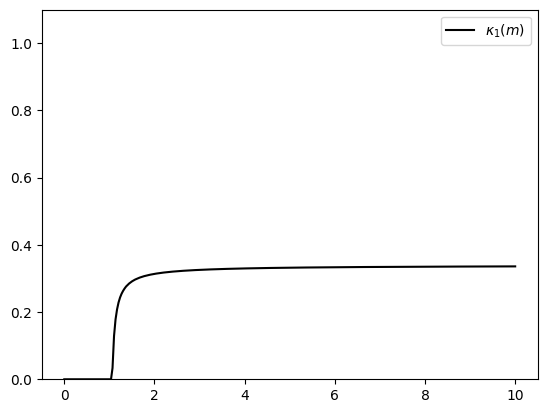

In [58]:
consumer.plot_κFunc(t=0)

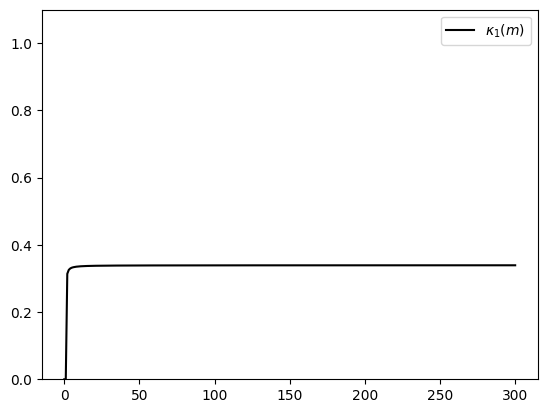

In [59]:
consumer.plot_κFunc(mGrid = mGrid, t=0)

In [21]:
Σ = gen_cov_matrix(0.014, kind="T")

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve()

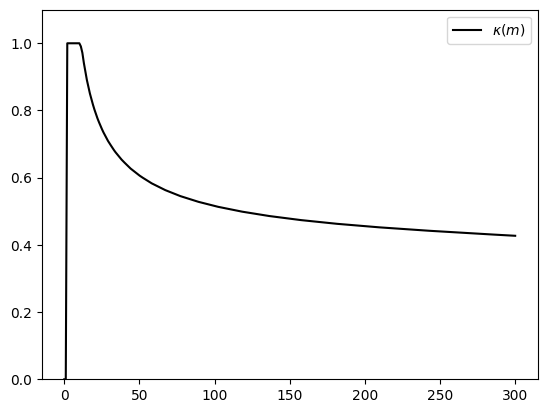

In [22]:
consumer.plot_κFunc(mGrid = mGrid)

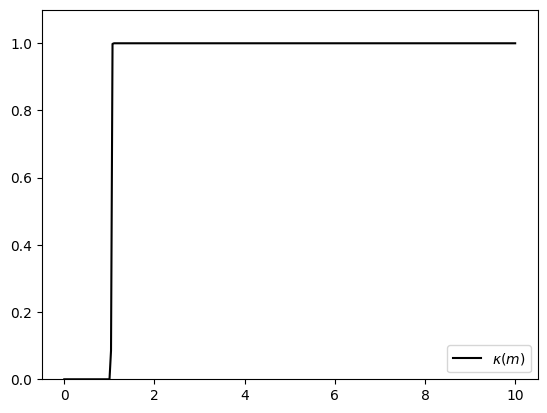

In [23]:
consumer.plot_κFunc()

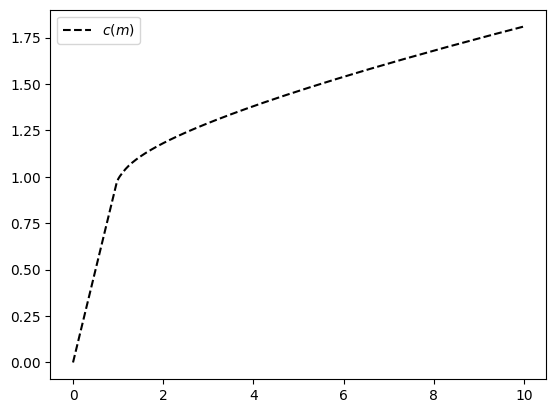

In [24]:
consumer.plot_cFunc()

In [25]:
m_star = consumer.target_wealth()
print(f'The target wealth for this consumer is {m_star}')

a_star = m_star - consumer.solution['cFunc'](m_star)
print(f'The target savings for this consumer is {a_star}')

κ_star = consumer.solution['κFunc'](m_star)
print(f'Consequently, this consumer invests {κ_star} proportion in equity')

The target wealth for this consumer is 1.0303827726578818
The target savings for this consumer is 0.030762000133232936
Consequently, this consumer invests 0.0 proportion in equity


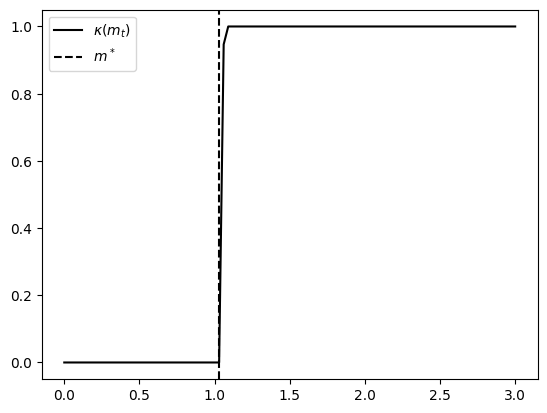

In [26]:
consumer.plot_targetκ(mGrid=np.linspace(0, 3, 100))

In [60]:
Σ = gen_cov_matrix(0.014, kind="T")

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve(T=1)

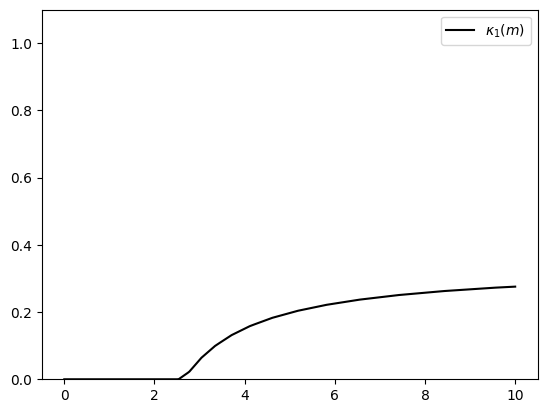

In [61]:
consumer.plot_κFunc(t = 0)

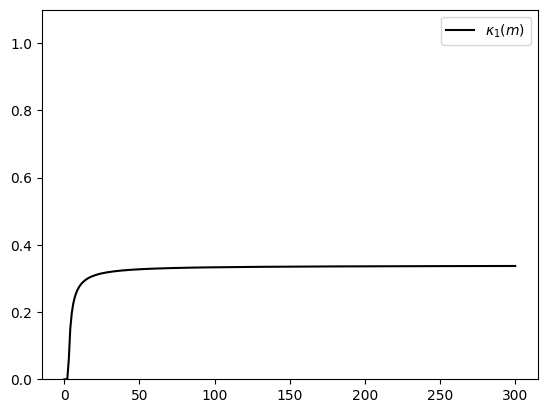

In [62]:
consumer.plot_κFunc(mGrid = mGrid, t = 0)

In [27]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = False, N=12)

consumer.solve()

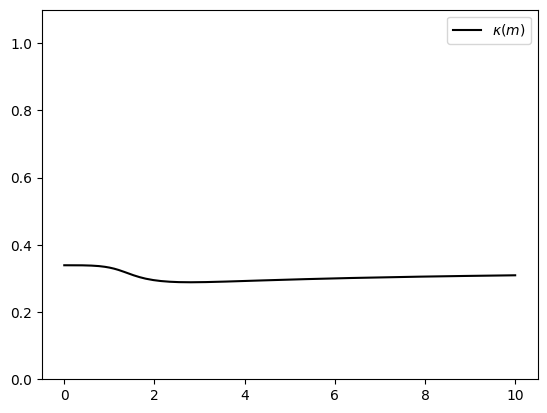

In [28]:
consumer.plot_κFunc()

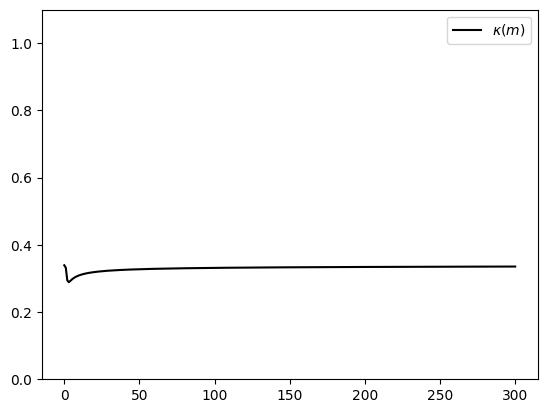

In [30]:
consumer.plot_κFunc(mGrid = mGrid)

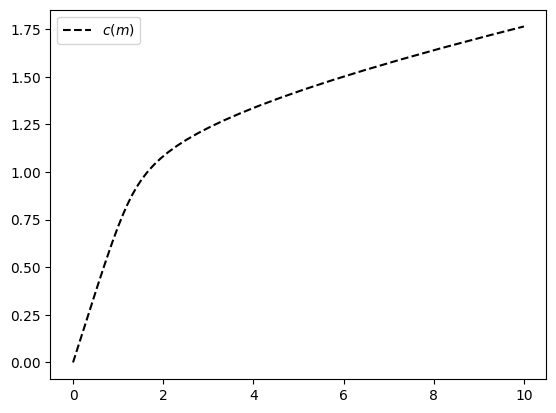

In [29]:
consumer.plot_cFunc()

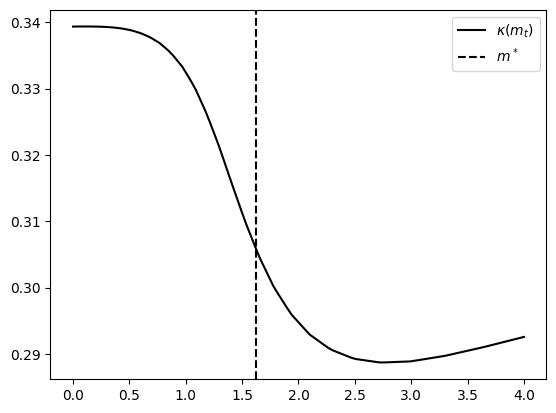

In [32]:
consumer.plot_targetκ(mGrid = np.linspace(0, 4, 100))

In [41]:
Σ = gen_cov_matrix(0.014, kind="T")

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = False, N=12)

consumer.solve()

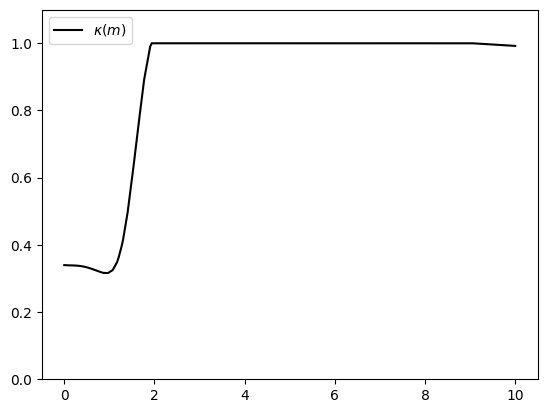

In [42]:
consumer.plot_κFunc()

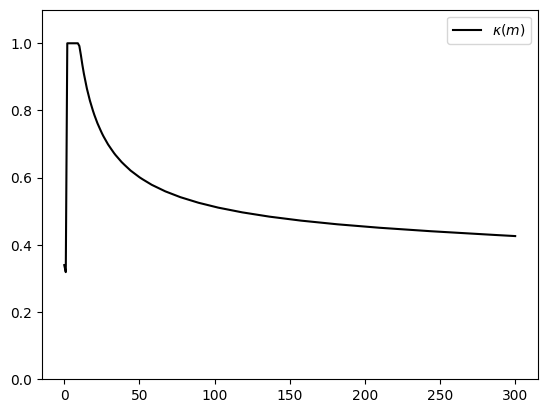

In [43]:
consumer.plot_κFunc(mGrid = mGrid)

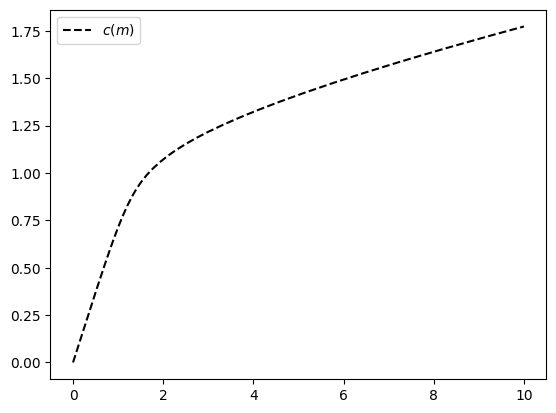

In [44]:
consumer.plot_cFunc()

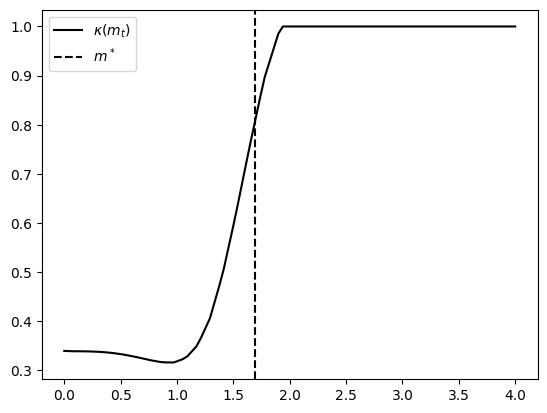

In [45]:
consumer.plot_targetκ(mGrid = np.linspace(0, 4, 100))

## Share Limit Check

### With Borrowing Constraints

In [35]:
Ω = [0.0025 * (i + 1) for i in range(5)]

consumers = []

for i in range(len(Ω)):
    
    Σ = gen_cov_matrix(Ω[i])
    
    consumer = BufferStockModel(Σ = Σ)
    
    consumer.pre_solve(aMax = 1000, n = 80, boroConst = True, N=12)
    
    consumer.solve()

    consumers.append(consumer)

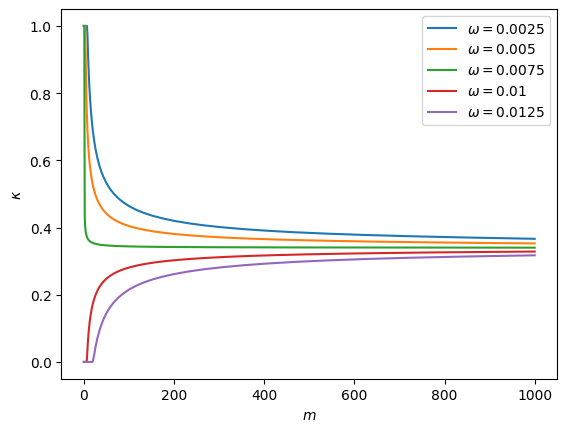

In [37]:
for i in range(len(consumers)):
    mGrid2 = np.linspace(0, 1000, 1000)

    plt.plot(mGrid2, consumers[i].solution['κFunc'](mGrid2), label = f"$ω = {Ω[i]}$")


plt.xlabel('$m$')
plt.ylabel('$\kappa$')

plt.legend()

In [52]:
Ω = [0.0028 * (i + 1) for i in range(5)]

consumers2 = []

for i in range(len(Ω)):
    
    Σ = gen_cov_matrix(Ω[i], kind="T")
    
    consumer = BufferStockModel(Σ = Σ)
    
    consumer.pre_solve(aMax = 1000, n = 80, boroConst = True, N=12)
    
    consumer.solve()

    consumers2.append(consumer)

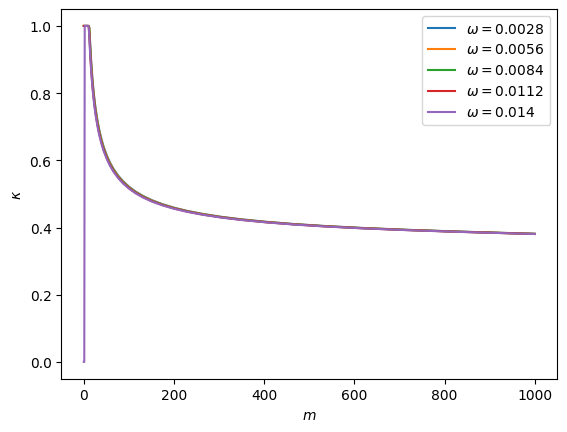

In [53]:
for i in range(len(consumers)):
    mGrid2 = np.linspace(0, 1000, 1000)

    plt.plot(mGrid2, consumers2[i].solution['κFunc'](mGrid2), label = f"$ω = {Ω[i]}$")


plt.xlabel('$m$')
plt.ylabel('$\kappa$')

plt.legend()

### With Zero Income Event

In [48]:
Ω = [0.0025 * (i + 1) for i in range(5)]

consumers_z = []

for i in range(len(Ω)):
    
    Σ = gen_cov_matrix(Ω[i])
    
    consumer = BufferStockModel(Σ = Σ)
    
    consumer.pre_solve(aMax = 1000, n = 80, boroConst = False, N=12)
    
    consumer.solve()

    consumers_z.append(consumer)

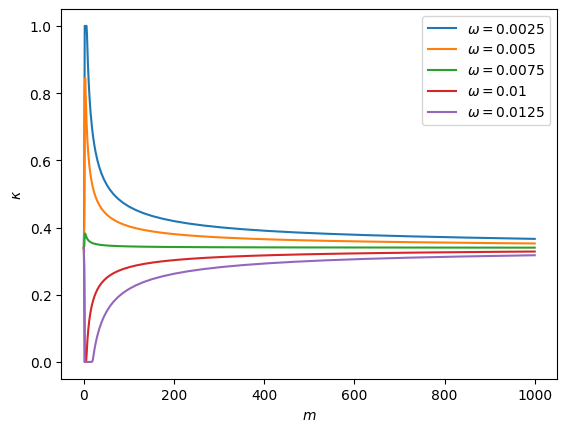

In [49]:
for i in range(len(consumers)):
    mGrid2 = np.linspace(0, 1000, 1000)

    plt.plot(mGrid2, consumers_z[i].solution['κFunc'](mGrid2), label = f"$ω = {Ω[i]}$")


plt.xlabel('$m$')
plt.ylabel('$\kappa$')

plt.legend()

In [54]:
Ω = [0.0028 * (i + 1) for i in range(5)]

consumers_z2 = []

for i in range(len(Ω)):
    
    Σ = gen_cov_matrix(Ω[i], kind="T")
    
    consumer = BufferStockModel(Σ = Σ)
    
    consumer.pre_solve(aMax = 1000, n = 80, boroConst = False, N=12)
    
    consumer.solve()

    consumers_z2.append(consumer)

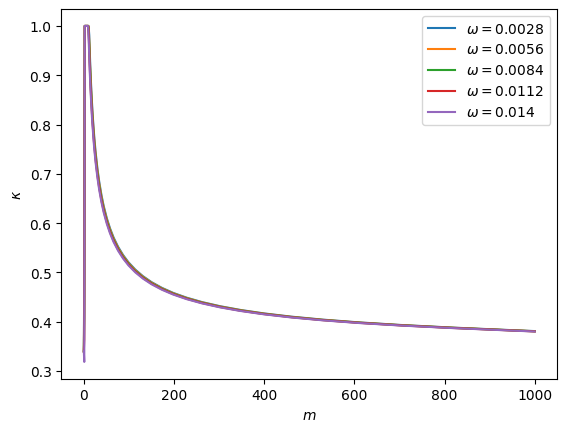

In [55]:
for i in range(len(consumers)):
    mGrid2 = np.linspace(0, 1000, 1000)

    plt.plot(mGrid2, consumers_z2[i].solution['κFunc'](mGrid2), label = f"$ω = {Ω[i]}$")


plt.xlabel('$m$')
plt.ylabel('$\kappa$')

plt.legend()

## US Data

In [63]:
def gen_us_cov_matrix(ω : float, kind = "P"):

    if kind == "P":
        Σ = np.array(
            [
                [0.01, ω, 0.0],
                [ω, 0.011, 0.0],
                [0.0, 0.0, 0.01]
            ]
        )
    elif kind == "T":
        Σ = np.array(
            [
                [0.01, 0.0, 0.0],
                [0.0, 0.011, ω],
                [0.0, ω, 0.01]
            ]
        )

    return Σ

In [121]:
Σ = gen_us_cov_matrix(0.01)

consumer = BufferStockModel(Σ = Σ, ℜ = 1.0767, Rf = 1.0131)

consumer.pre_solve(aMax = 300, n = 70, boroConst = True, N=12)

consumer.solve()

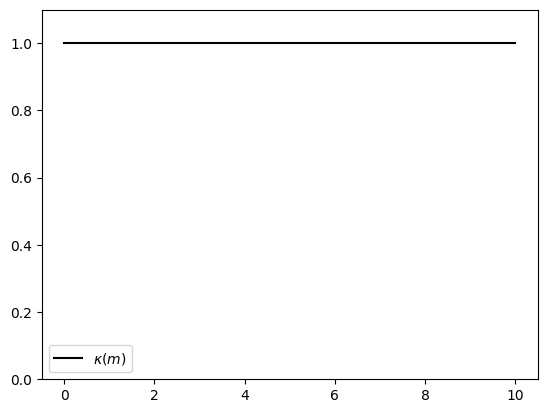

In [122]:
consumer.plot_κFunc()

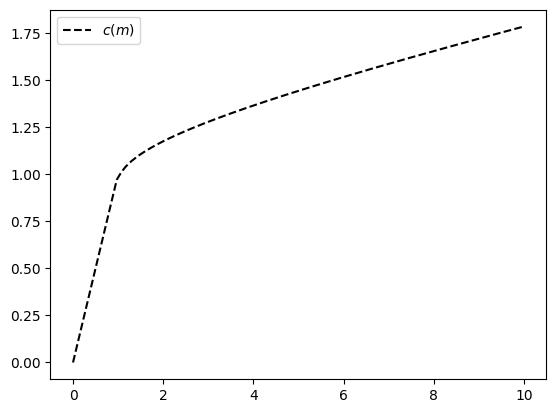

In [123]:
consumer.plot_cFunc()

In [134]:
Σ = gen_us_cov_matrix(0.01)

consumer = BufferStockModel(Σ = Σ, ℜ = 1.0767, Rf = 1.0131, ρ=12)

consumer.pre_solve(aMax = 300, n = 70, boroConst = True, N=12)

consumer.solve()

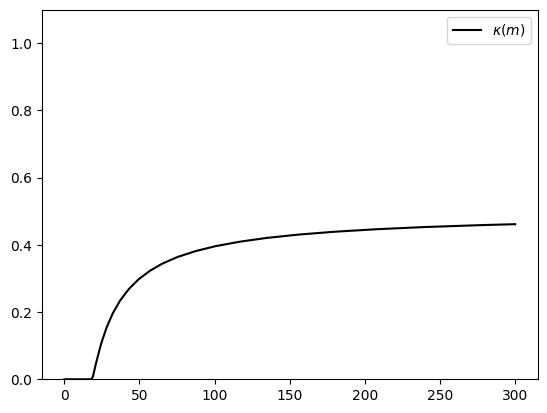

In [135]:
consumer.plot_κFunc(mGrid=mGrid)

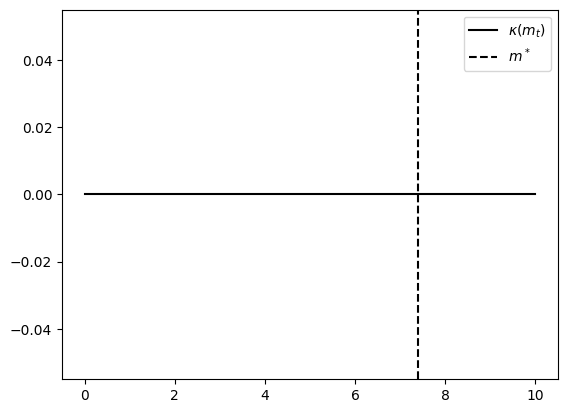

In [136]:
consumer.plot_targetκ()

In [138]:
Σ = gen_us_cov_matrix(0.01)

consumer = BufferStockModel(Σ = Σ, ℜ = 1.0767, Rf = 1.0131, ρ=7)

consumer.pre_solve(aMax = 300, n = 70, boroConst = True, N=12)

consumer.solve()

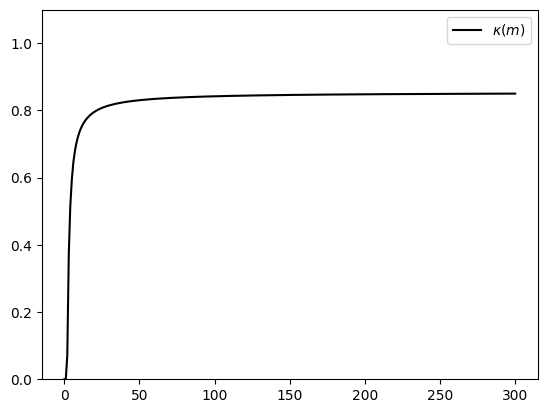

In [139]:
consumer.plot_κFunc(mGrid=mGrid)

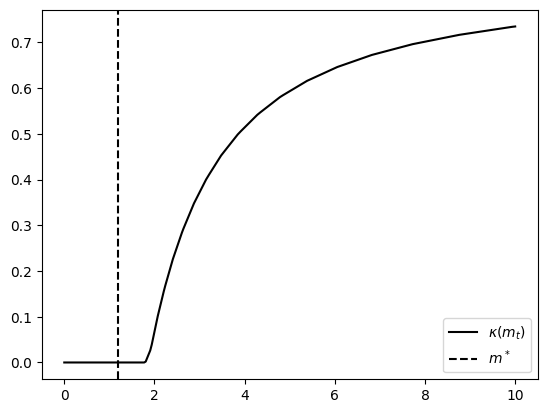

In [140]:
consumer.plot_targetκ()

In [77]:
Σ = gen_us_cov_matrix(0.01)

consumer = BufferStockModel(Σ = Σ, ℜ = 1.0767, Rf = 1.0131)

consumer.pre_solve(aMax = 300, n = 70, boroConst = False, N=12)

consumer.solve()

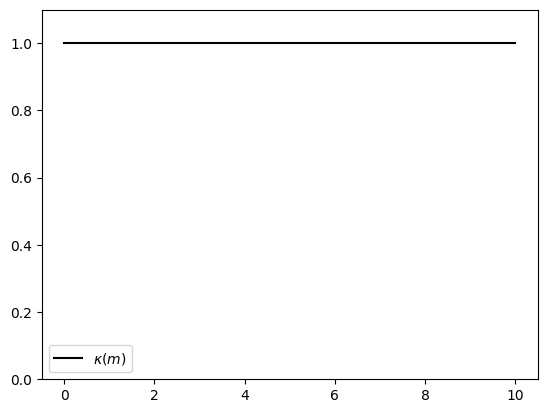

In [70]:
consumer.plot_κFunc()

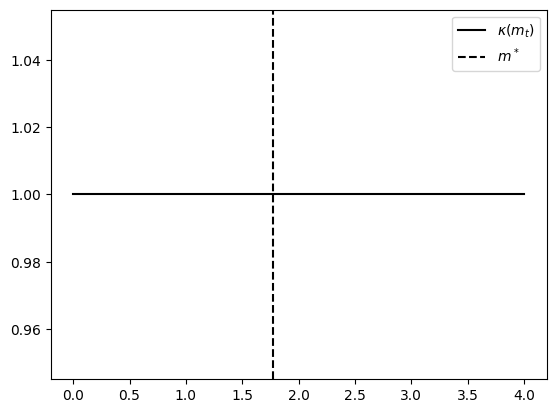

In [71]:
consumer.plot_targetκ(mGrid = np.linspace(0, 4, 100))

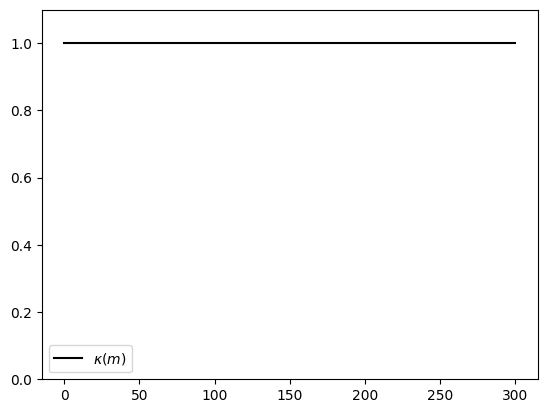

In [73]:
consumer.plot_κFunc(mGrid = mGrid)

In [144]:
Σ = gen_us_cov_matrix(0.01)

consumer = BufferStockModel(Σ = Σ, ℜ = 1.0767, Rf = 1.0131, ρ = 7.5)

consumer.pre_solve(aMax = 300, n = 70, boroConst = False, N=12)

consumer.solve()

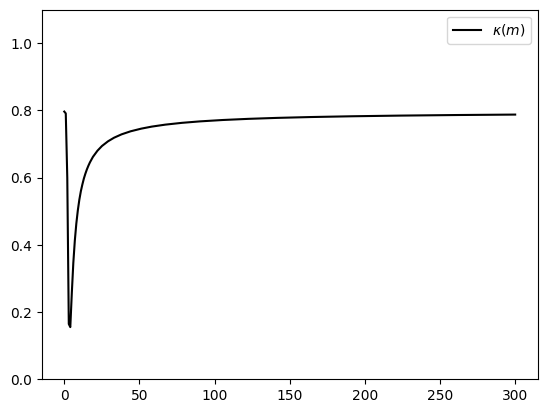

In [145]:
consumer.plot_κFunc(mGrid=mGrid)

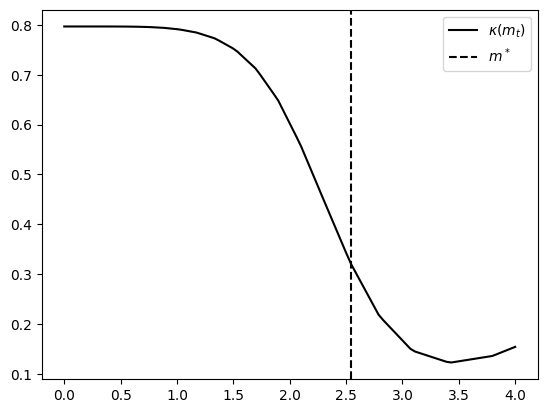

In [146]:
consumer.plot_targetκ(mGrid = np.linspace(0, 4, 100))

In [149]:
Σ = gen_us_cov_matrix(0.01)

consumer = BufferStockModel(Σ = Σ, ℜ = 1.0767, Rf = 1.0131, ρ = 12)

consumer.pre_solve(aMax = 300, n = 70, boroConst = False, N=12)

consumer.solve()

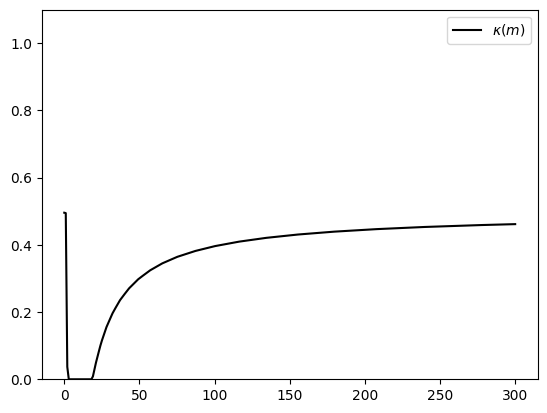

In [150]:
consumer.plot_κFunc(mGrid = mGrid)

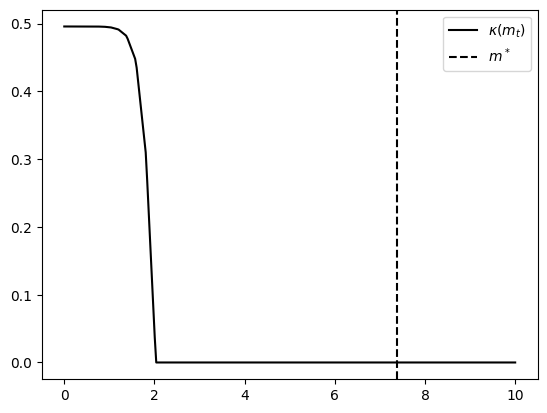

In [151]:
consumer.plot_targetκ()

In [12]:
Σ = gen_cov_matrix(0.012)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve()

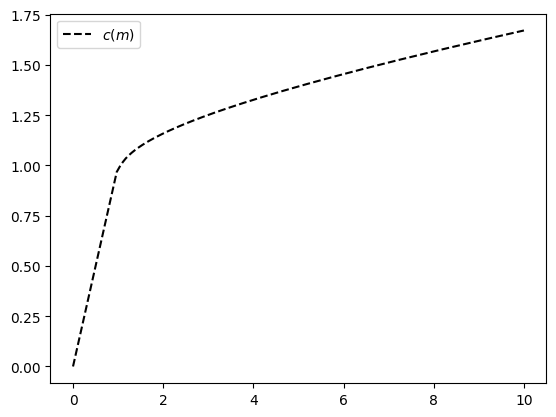

In [13]:
consumer.plot_cFunc()

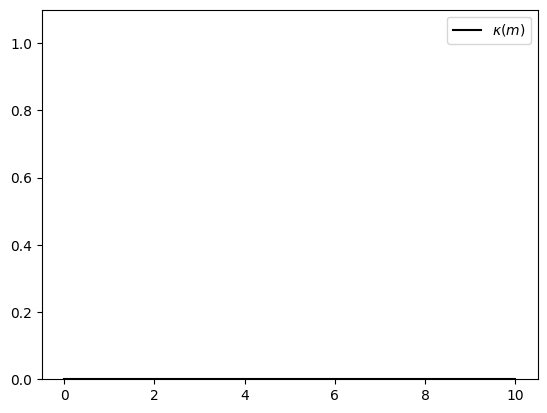

In [14]:
consumer.plot_κFunc()

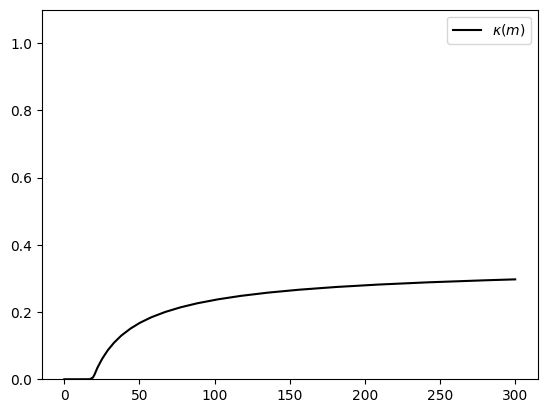

In [15]:
consumer.plot_κFunc(mGrid=mGrid)

In [4]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve(T=1)

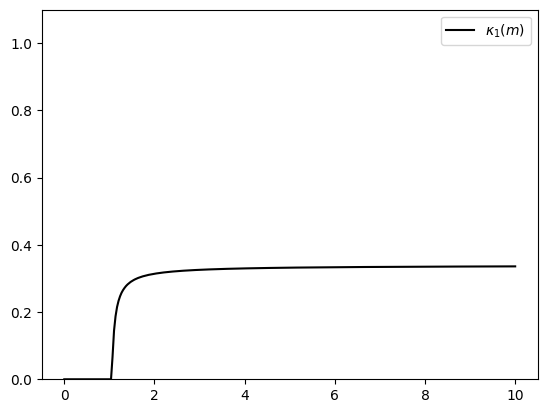

In [6]:
mGrid = np.linspace(0, 300, 300)

consumer.plot_κFunc(t=0)

In [16]:
def gen_cov_matrix(ω : float, kind = "P"):

    if kind == "P":
        Σ = np.array(
            [
                [0.01, ω, 0.0],
                [ω, 0.011, 0.0],
                [0.0, 0.0, 0.01]
            ]
        )
    elif kind == "T":
        Σ = np.array(
            [
                [0.01, 0.0, 0.0],
                [0.0, 0.011, ω],
                [0.0, ω, 0.01]
            ]
        )

    return Σ

In [20]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ, ℜ = 1.0767, Rf = 1.0131)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve()

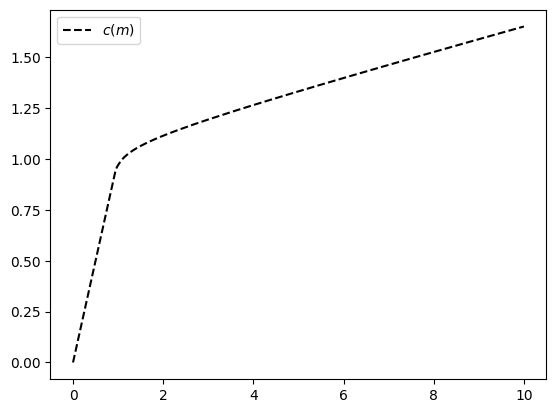

In [22]:
consumer.plot_cFunc()

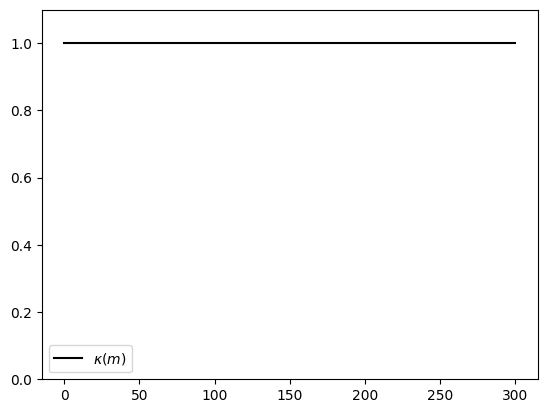

In [21]:
consumer.plot_κFunc(mGrid=mGrid)

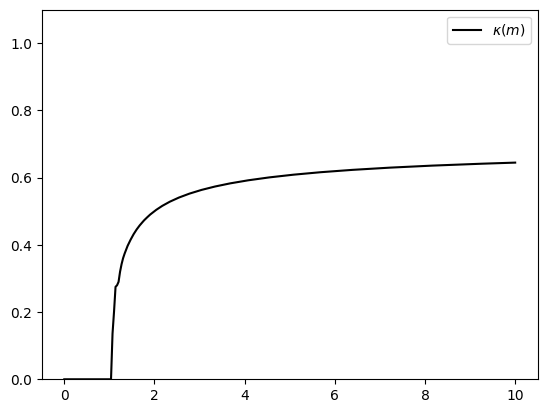

In [19]:
consumer.plot_κFunc()

In [17]:
consumer = BufferStockModel()

consumer.pre_solve(aMax = 300, n=70, boroConst=True, N=12)

consumer.solve()

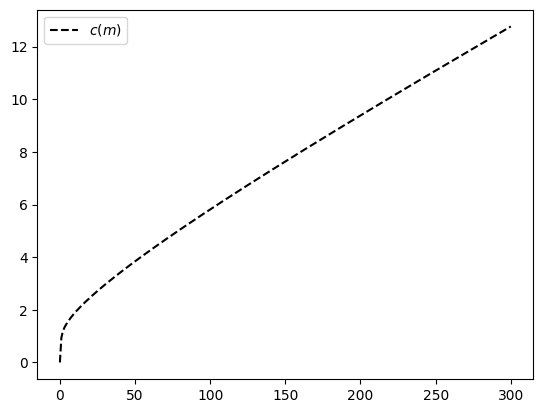

In [18]:
mGrid = np.linspace(0, 300, 300)

consumer.plot_cFunc(mGrid = mGrid)

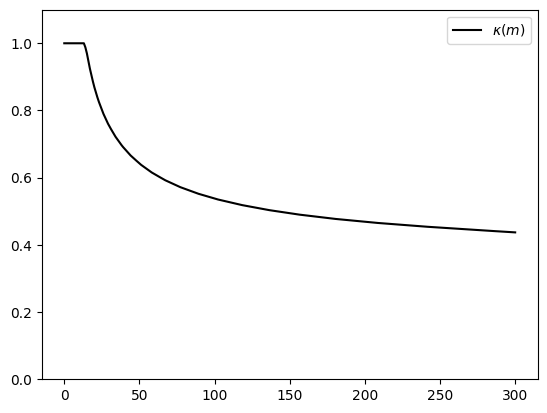

In [19]:
consumer.plot_κFunc(mGrid = mGrid)

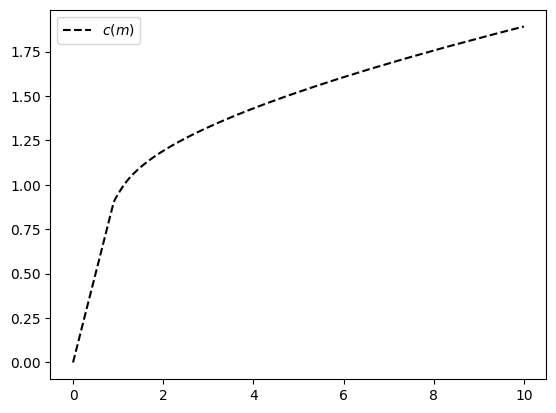

In [20]:
consumer.plot_cFunc()

In [ ]:
def gen_cov_matrix(ω : float, kind = "P"):

    if kind == "P":
        Σ = np.array(
            [
                [0.04/11, ω, 0.0],
                [ω, 0.0225, 0.0],
                [0.0, 0.0, 0.04]
            ]
        )
    elif kind == "T":
        Σ = np.array(
            [
                [0.04/11, 0.0, 0.0],
                [0.0, 0.0225, ω],
                [0.0, ω, 0.04]
            ]
        )

    return Σ

In [22]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve()

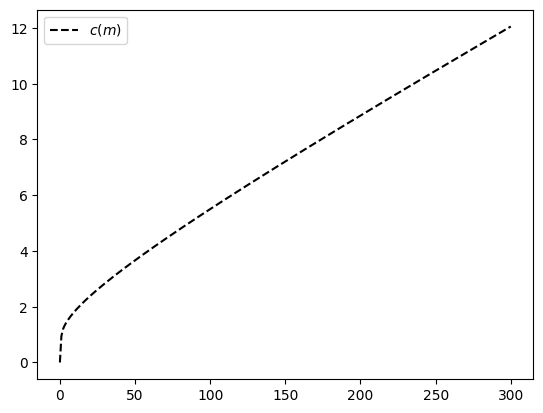

In [23]:
consumer.plot_cFunc(mGrid = mGrid)

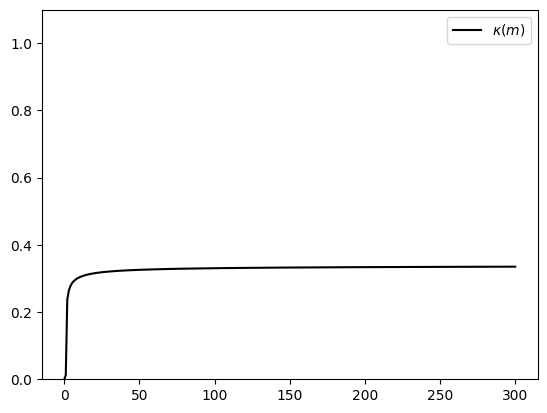

In [24]:
consumer.plot_κFunc(mGrid = mGrid)

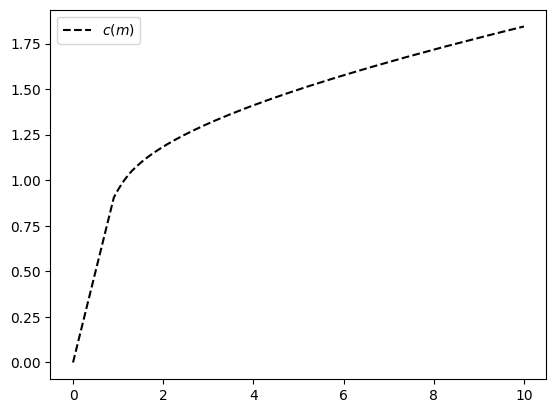

In [25]:
consumer.plot_cFunc()

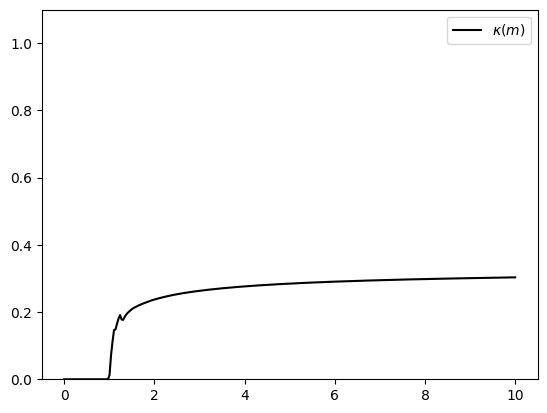

In [26]:
consumer.plot_κFunc()

In [13]:
Σ = gen_cov_matrix(0.025, kind="T")

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 50, boroConst = True)

consumer.solve()

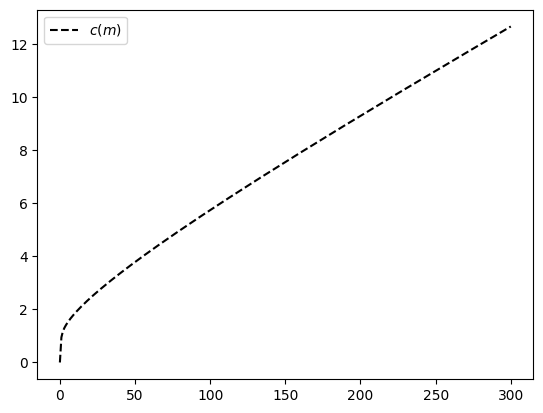

In [14]:
consumer.plot_cFunc(mGrid = mGrid)

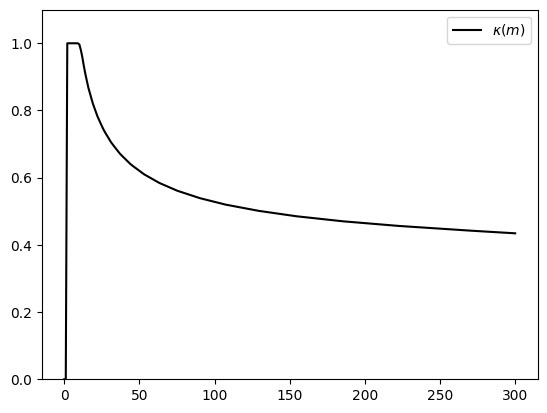

In [15]:
consumer.plot_κFunc(mGrid = mGrid)

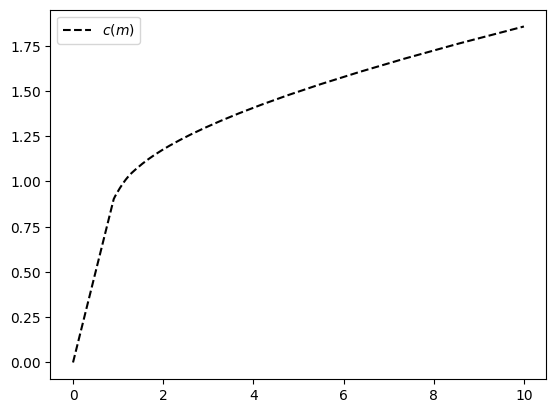

In [16]:
consumer.plot_cFunc()

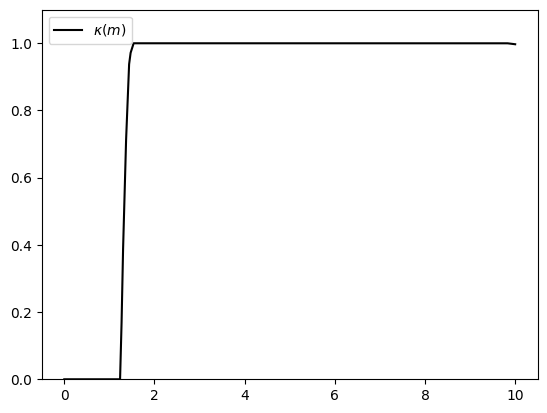

In [17]:
consumer.plot_κFunc()

In [46]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 50, boroConst = True)

consumer.solve(T = 5)

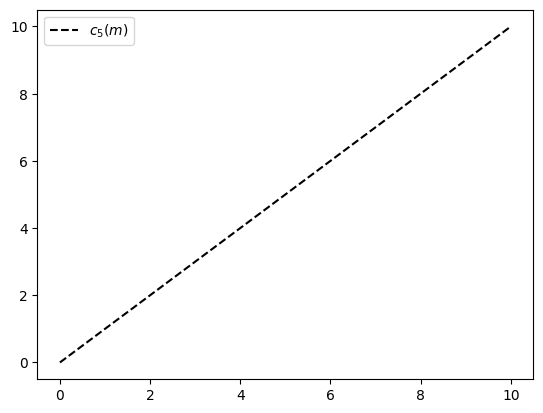

In [48]:
consumer.plot_cFunc(t=5)

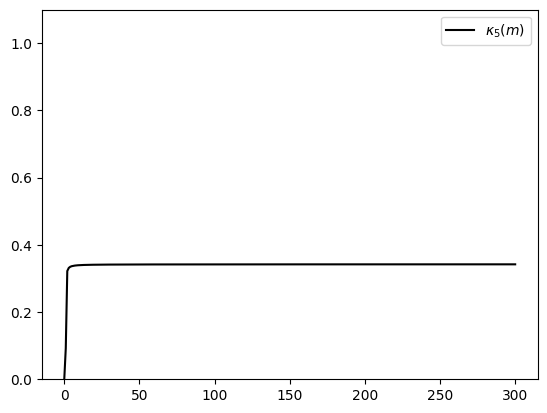

In [52]:
consumer.plot_κFunc(t=4, mGrid=mGrid)

In [15]:
ω = np.sqrt(0.011 * 0.04 / 11)

Σ = np.array(
    [
        [0.04/11, ω, 0.0],
        [ω, 0.011, 0.0],
        [0.0, 0.0, 0.04]
    ]
)

cons = BufferStockModel(ρ = 11, ℜ = 1.0767, Rf = 1.0131, Σ = Σ)

cons.pre_solve(aMax=300, n=50, boroConst=True, decomp="sqrt")

cons.solve()

In [17]:
cons.plot_κFunc(mGrid=mGrid)

NameError: name 'mGrid' is not defined

In [58]:
Σ = np.array(
    [
        [0.04/11, 0.0063, 0.0],
        [0.0063, 0.011, 0.0],
        [0.0, 0.0, 0.04]
    ]
)

cons = BufferStockModel(ρ = 12, ℜ = 1.0767, Rf = 1.0131, Σ = Σ)

cons.pre_solve(aMax=300, n=50, boroConst=True)

cons.solve()

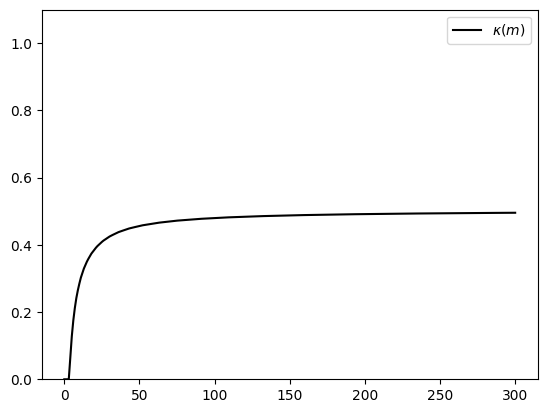

In [59]:
cons.plot_κFunc(mGrid=mGrid)

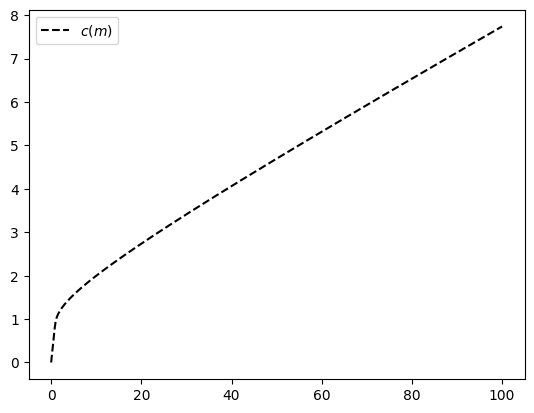

In [6]:
mGrid = np.linspace(0, 100, 500)

consumer.plot_cFunc(mGrid = mGrid)

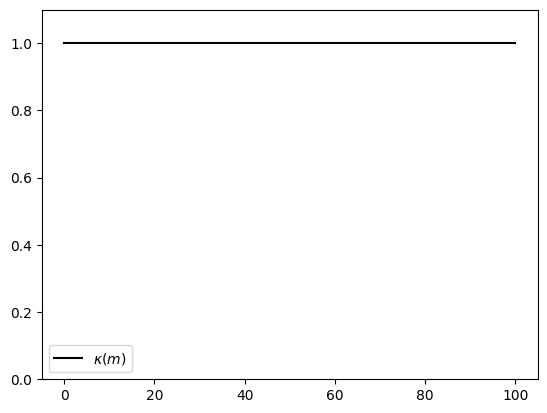

In [7]:
consumer.plot_κFunc(mGrid = mGrid)